In [9]:
import pickle
import os

# Carregar a lista 'sequences' de um arquivo usando pickle
# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])


caminho_pkl = os.path.join(parent_dir[0], "Word2Vec\\sequences.pickle")

with open(caminho_pkl, 'rb') as handle:
    sequences = pickle.load(handle)

In [10]:
import numpy as np

# Calcula o comprimento de cada sequência em 'sequences' e armazena os resultados na lista 'sequence_lengths'
sequence_lengths = [len(seq) for seq in sequences]

# Calcula a média dos comprimentos das sequências usando a função 'mean' do numpy
mean_length = np.mean(sequence_lengths)

# Obtém o comprimento máximo das sequências usando a função 'max' do Python
max_length = max(sequence_lengths)

# Imprime a média e o comprimento máximo das sequências
print("Mean sequence length: ", mean_length)
print("Maximum sequence length: ", max_length)

Mean sequence length:  173.9763956201759
Maximum sequence length:  3835


In [11]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Calcula uma porcentagem de 95% dos comprimentos das sequências (preserva 95% das sequências)
max_length = int(np.percentile(sequence_lengths, 95))

# Realiza o preenchimento das sequências com base no novo 'max_length'
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [12]:
import pandas as pd
import os

# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

parent_dir = os.path.split(parent_dir[0])

caminho_pkl = os.path.join(parent_dir[0], "Pre-processamento\\noticias_pre_processadas_df.pkl")

# Carregar dataframe salvo em formato pickle
df = pd.read_pickle(caminho_pkl)

In [13]:
df['label'].nunique() # Retorna o número de categorias únicas (classes) presentes na coluna 'label'

2

In [14]:
import tensorflow.keras.utils as ku

# Converte os labels para one-hot encoding
num_classes = df['label'].nunique()
labels = ku.to_categorical(df['label'], num_classes)

In [15]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [16]:
from sklearn.model_selection import train_test_split

# Divisão dos dados em um conjunto de treino (70%) e um conjunto temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3)

# Divisão do conjunto temporário em conjuntos de validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)  

In [17]:
# Treinamento da BiLSTM
import tensorflow as tf
print("Num GPUs: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs:  1


In [18]:
from gensim.models import Word2Vec
import os

# Carrega o modelo Word2Vec para um arquivo

# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

caminho_model = os.path.join(parent_dir[0], "Word2Vec\\modelo_word2vec.model")

word2vec_model = Word2Vec.load(caminho_model)

In [19]:
# Importações das bibliotecas necessárias do TensorFlow e Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Criação do modelo Sequential
model = Sequential()

# Adiciona uma camada de Embedding para representação das palavras
# input_dim é o tamanho do vocabulário mais 1 para lidar com palavras desconhecidas
# output_dim é o tamanho dos vetores de embedding
# input_length é o comprimento máximo das sequências de entrada
model.add(Embedding(input_dim=len(word2vec_model.wv.key_to_index) + 1, 
                    output_dim=word2vec_model.vector_size, input_length=max_length))

# Adiciona uma camada Bidirectional LSTM com regularização L2
# Retorna sequências para manter informações de contexto
model.add(Bidirectional(LSTM(units=128, return_sequences=True, 
                             kernel_regularizer=tf.keras.regularizers.l2(0.001))))

# Adiciona uma camada de Dropout para prevenir overfitting
model.add(Dropout(0.5))

# Adiciona mais uma camada Bidirectional LSTM com regularização L2
# Retorna sequências
model.add(Bidirectional(LSTM(units=64, return_sequences=True, 
                             kernel_regularizer=tf.keras.regularizers.l2(0.001))))

# Adiciona outra camada de Dropout
model.add(Dropout(0.5))

# Adiciona uma última camada Bidirectional LSTM sem retorno de sequência
# com regularização L2
model.add(Bidirectional(LSTM(units=32, kernel_regularizer=tf.keras.regularizers.l2(0.001))))

# Adiciona uma camada densa (fully connected) com ativação softmax
# para a classificação das saídas
model.add(Dense(units=len(labels[0]), activation='softmax'))

# Define um callback para parar o treinamento prematuramente
# se a perda de validação não melhorar após um certo número de épocas
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Compilação do modelo
# usa a função de perda categorical_crossentropy para problemas de classificação multiclasse
# otimizador Adam é usado para ajustar os pesos da rede
# métrica de avaliação é a acurácia
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treina o modelo
# com os dados de treinamento e rótulos de treinamento
# por um número específico de épocas
# utilizando um tamanho de lote definido
# monitorando a perda de validação e parando o treinamento prematuramente se necessário
history = model.fit(X_train, y_train, epochs=40, batch_size=64, 
                    validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)


Epoch 1/40
244/244 [==============================] - 129s 469ms/step - loss: 0.5540 - accuracy: 0.8676 - val_loss: 0.2763 - val_accuracy: 0.9297
Epoch 2/40
244/244 [==============================] - 112s 458ms/step - loss: 0.1723 - accuracy: 0.9619 - val_loss: 0.4126 - val_accuracy: 0.8489
Epoch 3/40
244/244 [==============================] - 116s 475ms/step - loss: 0.1330 - accuracy: 0.9680 - val_loss: 0.2871 - val_accuracy: 0.9267
Epoch 4/40
244/244 [==============================] - 117s 480ms/step - loss: 0.0677 - accuracy: 0.9872 - val_loss: 0.4362 - val_accuracy: 0.8878
Epoch 5/40
244/244 [==============================] - 117s 481ms/step - loss: 0.0428 - accuracy: 0.9932 - val_loss: 0.3124 - val_accuracy: 0.9189
Epoch 6/40
244/244 [==============================] - 117s 478ms/step - loss: 0.0280 - accuracy: 0.9967 - val_loss: 0.3115 - val_accuracy: 0.9369


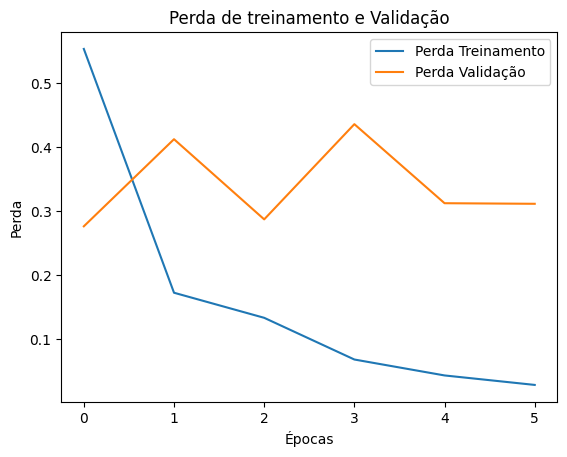

In [20]:
import matplotlib.pyplot as plt

# Plota a perda (loss) e a perda de validação (val_loss) durante o treinamento
plt.plot(history.history['loss'], label='Perda Treinamento')
plt.plot(history.history['val_loss'], label='Perda Validação')
plt.title('Perda de treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [21]:
# Salva arquivos em discos que podemos carregar sem treinar a rede neural novamente
model.save('modelo_BiLSTM.h5')
np.save("X_test_BiLSTM.npy", X_test)
np.save("y_test_BiLSTM.npy", y_test)

In [22]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Acurácia final:', accuracy)

Acurácia final: 0.9398743510246277


In [23]:
# Fazer as previsões do modelo para o conjunto de teste
y_pred = model.predict(X_test)

105/105 [==============================] - 19s 167ms/step


In [24]:
#Transformar as previsões de volta em labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

conf_mat

array([[1660,   67],
       [ 134, 1482]], dtype=int64)

In [25]:
import pandas as pd
import os

# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

parent_dir = os.path.split(parent_dir[0])

caminho_pkl = os.path.join(parent_dir[0], "Pre-processamento\\noticias_pre_processadas_df.pkl")

# Carregar dataframe salvo em formato pickle
df = pd.read_pickle(caminho_pkl)

# Total de classes
classes = df['label'].nunique()


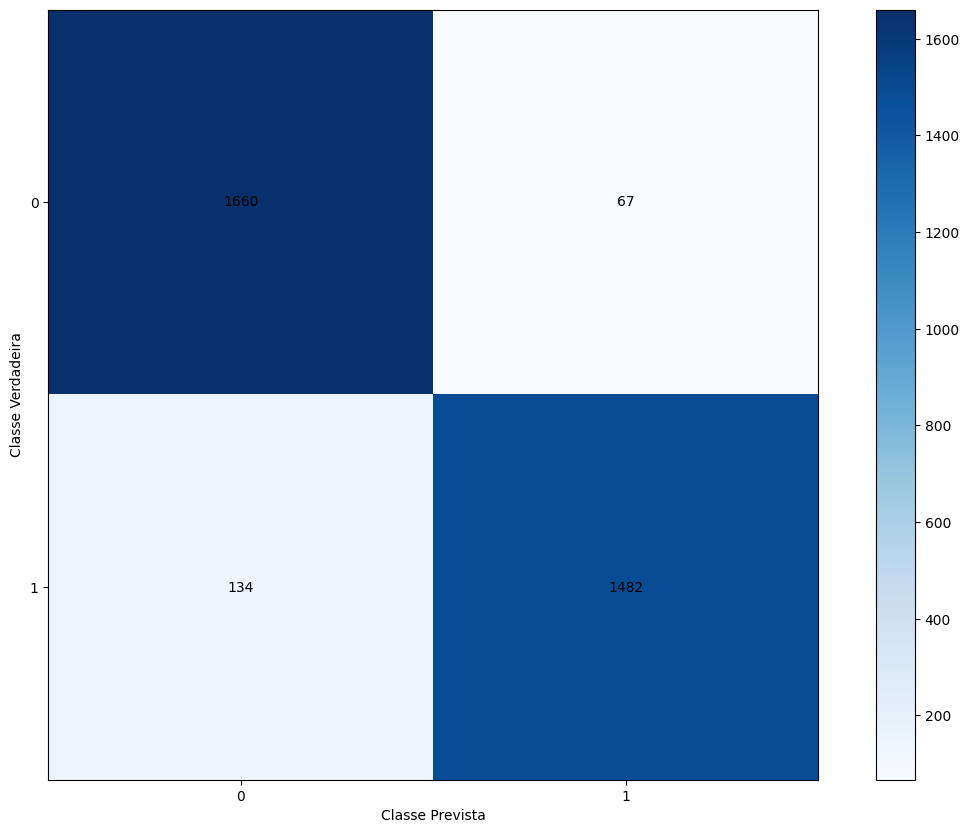

In [26]:
import matplotlib.pyplot as plt

# Define o tamanho da figura
plt.figure(figsize=(15, 10))

# Define mapa de cores
cmap = plt.cm.Blues

# Plota matriz de confusão
plt.imshow(conf_mat, cmap=cmap)
plt.colorbar()

# Adiciona labels a matriz
plt.xticks([int(i) for i in range(2)], [str(i) for i in range(2)])
plt.yticks([int(i) for i in range(2)], [str(i) for i in range(2)])

for i in range(classes):
    for j in range(classes):
        plt.text(j, i, str(conf_mat[i, j]), ha='center', va='center', color='white' if conf_mat[i, j] > len(y_true_labels)/ classes else 'black')

# Adiciona rótulos dos eixos
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')

# Mostra o plot
plt.show()

In [27]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcula precisão, recall e f1-score para cada classe
precisions = []
recalls = []
f1_scores = []
for i in range(classes):
    precision = precision_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    recall = recall_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    f1 = f1_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
# Printa resultados
for i in range(classes):
    print(f"Classe '{i}': Precisão={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1-Score={f1_scores[i]:.4f}")

# Calcula e printa a média dos f1-scores
f1_average = np.mean(f1_scores)
print(f"F1-Score médio: {f1_average:.4f}")

Classe '0': Precisão=0.9253, Recall=0.9612, F1-Score=0.9429
Classe '1': Precisão=0.9567, Recall=0.9171, F1-Score=0.9365
F1-Score médio: 0.9397
